# Table of Contents
 <p><div class="lev1 toc-item"><a data-toc-modified-id="Simulation-parameters-1" href="#Simulation-parameters"><span class="toc-item-num">1&nbsp;&nbsp;</span>Simulation parameters</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Extended-point-neuron-model-(eP)-2" href="#Extended-point-neuron-model-(eP)"><span class="toc-item-num">2&nbsp;&nbsp;</span>Extended point neuron model (eP)</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Initialize-the-eP-model-2.1" href="#Initialize-the-eP-model"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize the eP model</a></div><div class="lev2 toc-item"><a data-toc-modified-id="eP-model-in-response-to-fluctuating-input-at-the-soma-and-distal-dendrite-2.2" href="#eP-model-in-response-to-fluctuating-input-at-the-soma-and-distal-dendrite"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>eP model in response to fluctuating input at the soma and distal dendrite</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Ball-and-Stick-neuron-model-(BS)-3" href="#Ball-and-Stick-neuron-model-(BS)"><span class="toc-item-num">3&nbsp;&nbsp;</span>Ball-and-Stick neuron model (BS)</a></div><div class="lev2 toc-item"><a data-toc-modified-id="Create-the-BS-model-in-Neuron-3.1" href="#Create-the-BS-model-in-Neuron"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Create the BS model in Neuron</a></div><div class="lev1 toc-item"><a data-toc-modified-id="Simulations-4" href="#Simulations"><span class="toc-item-num">4&nbsp;&nbsp;</span>Simulations</a></div><div class="lev2 toc-item"><a data-toc-modified-id="BS-and-eP-model-neurons-exposed-to-a-weak-extracellular-field-4.1" href="#BS-and-eP-model-neurons-exposed-to-a-weak-extracellular-field"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>BS and eP model neurons exposed to a weak extracellular field</a></div><div class="lev2 toc-item"><a data-toc-modified-id="BS-and-eP-model-neurons-in-response-to-somatic-input-4.2" href="#BS-and-eP-model-neurons-in-response-to-somatic-input"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>BS and eP model neurons in response to somatic input</a></div><div class="lev2 toc-item"><a data-toc-modified-id="BS-and-eP-model-neurons-in-response-to-input-at-the-distal-dendrite-4.3" href="#BS-and-eP-model-neurons-in-response-to-input-at-the-distal-dendrite"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>BS and eP model neurons in response to input at the distal dendrite</a></div><div class="lev2 toc-item"><a data-toc-modified-id="BS-and-eP-model-neurons-in-response-to-input-at-soma-and-dendrite-+-sinusoidal-field-4.4" href="#BS-and-eP-model-neurons-in-response-to-input-at-soma-and-dendrite-+-sinusoidal-field"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>BS and eP model neurons in response to input at soma and dendrite + sinusoidal field</a></div>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba

In [2]:
from ePModel import ePModel

In [3]:
%matplotlib inline

In [4]:
isNEURONInstalled = True  # set True only if a working installation of NEURON and its python binding (pyneuron) is available

# Simulation parameters

In [5]:
C_dend      = 1.0e-2    # Dendritic membrane capacitance (F / m2)
rhom_dend   = 28.0e-1   # Dendritic membrane resistivity (Ohm m2)
rha_dend    = 1.5       # Dendritic membrane internal resistivity (Ohm m)
d_dend      = 1.2e-6    # Dendritic cable diameter (m)
L_dend      = 700.0e-6  # Dendritic cable length (m)

# Soma (here we take the same values for the soma and dendrite as in Rattay 1999)
C_soma      = 1.0e-2    # Somatic membrane capacitance (F / m2)
rhom_soma   = 28.0e-1   # Somatic membrane resistivity (Ohm m2)
d_soma      = 10e-6     # Soma diameter (m)
E_freq      = 10.       # Field frequency (Hz)
E_amp       = 1.        # Field amplitude (V/m)
E_n         = 20        # Number of cycles the field is applied
E_onset     = 0         # Field onset time (ms)

In [6]:
V0      = 0.     # Base membrane voltage in this absence of input (mV)
VT      = 10.    # Spike threshold (mV)
T_ref   = 1.5    # Refractory time after each spike (ms)  

In [7]:
duration= 3000.     # Simulation duration (ms)

In [8]:
OUNoise_soma_mean   = 0.003 # Mean of the noisy somatic input (nA)
OUNoise_soma_std    = 0.01  # Standard deviation of the Ornstein-Uhlenbeck process for the somatic input (nA)
OUNoise_dend_mean   = 0.003 # Mean of the noisy dendritic input (nA)
OUNoise_dend_std    = 0.01  # Standard deviation of the Ornstein-Uhlenbeck process for the dendritic input (nA)

# Extended point neuron model (eP)

## Initialize the eP model

In [9]:
eP = ePModel()

## eP model in response to fluctuating input at the soma and distal dendrite

In this section we simuate the eP neuron model subject to noisy somatic and distal dendritic input currents given by Ornstein-Uhlenbeck processes. The BS model is not included here.

In [10]:
@numba.njit
def generateOUNoise(t_s,Tau_OU_s, stdOU):
    '''
    This function generates an Ornstein-Uhlenbeck process realization

    Parameters:
        :param t_s:         Time samples for the OU process
        :param Tau_OU_s:    OU process time constant
        :param stdOU:       OU process standard deviation
    
    :returns OUNoise:       OU process realization
    '''
    OUNoise = np.zeros_like(t_s)

    if Tau_OU_s == 0.:
        for i in xrange(len(OUNoise)):
            OUNoise[i] = stdOU * np.random.randn()
        return OUNoise

    OUNoise = np.zeros_like(t_s)
    dt  = t_s[1] - t_s[0]
    D   = 2 * stdOU * stdOU / Tau_OU_s
    mu  = np.exp(-dt/Tau_OU_s)
    amp = stdOU * np.sqrt( (1-np.exp(-2*dt/Tau_OU_s)) )

    for i in xrange(len(t_s) - 1):
        OUNoise[i+1]= mu * OUNoise[i] + amp * np.random.randn()

    return OUNoise

In [11]:
dt = 0.1 # Integration time in ms

In [12]:
t = np.arange(0,duration,dt)

In [13]:
OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean

In [14]:
# Compute the input currents for the eP model
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=dt*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

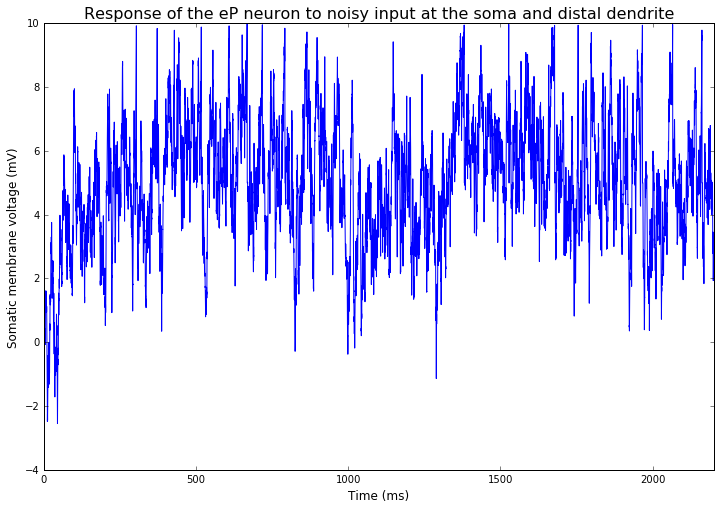

In [15]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3)
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([0,2200])
plt.title('Response of the eP neuron to noisy input at the soma and distal dendrite', fontsize=16)
# Note that the membrane voltage here denotes the difference to the membrane voltage at rest  

# Ball-and-Stick neuron model (BS)

In the following section a working installation of NEURON and its python binding (pyneuron) is needed in order to run the BS model.

In [16]:
if isNEURONInstalled:
    import sys
    sys.path.append("/usr/local/nrn/lib/python/") # Add pyneuron path
    import neuron

## Create the BS model in Neuron

In [17]:
if isNEURONInstalled:
    h = neuron.h

    # Load BS structure
    h('load_file("BS_morphology.hoc")')

    # Add vector to record diverse variables
    h('objref tVec')
    h('tVec = new Vector()')
    h.tVec.record(h._ref_t)

    # Somatic membrane voltage
    h('objref v0Vec')
    h('v0Vec = new Vector()')
    h.v0Vec.record(h.dend(0)._ref_v)

    # Field
    h('objref fsinVec')
    h('fsinVec = new Vector()')
    h.fsinVec.record(h.fsin._ref_x)

    t   = h.tVec
    v0  = h.v0Vec

    # Input noise
    # OU noise = background noise

    h("access soma")
    h("objref spkout")
    h("spkout = new SpikeOut(0.5)")


    # Add OU noise input at the soma
    h("access soma")
    h("objref OUNoiseStim")
    h("OUNoiseStim = new IClampOU(0.5)")
    h('objref OUNoiseVec')
    h('OUNoiseVec = new Vector()')
    h.OUNoiseVec.record(h.OUNoiseStim._ref_i)


    # Add OU noise input at the dendritic end
    h("access dend")
    h("objref OUNoiseStim_dend")
    h("OUNoiseStim_dend = new IClampOU(1)")
    h('objref OUNoiseVec_dend')
    h('OUNoiseVec_dend = new Vector()')
    h.OUNoiseVec_dend.record(h.OUNoiseStim_dend._ref_i)


    h.OUNoiseStim.mean        = OUNoise_soma_mean
    h.OUNoiseStim.std         = OUNoise_soma_std

    h.OUNoiseStim_dend.mean   = OUNoise_dend_mean
    h.OUNoiseStim_dend.std    = OUNoise_dend_std

    h.OUNoiseStim.tau         = 0.5
    h.OUNoiseStim_dend.tau    = 0.5


    # Set the BS model parameters
    ## Soma
    h.soma.diam = d_soma * 1e6    # um
    h.soma.L    = d_soma * 1e6    # um
    h.soma.Ra   = rha_dend * 1e2  # Ohm cm

    for seg in h.soma:
        seg.cm      = C_soma * 1e2    # uF / cm2
        seg.pas.g   = 1.0/(rhom_soma * 1e4)   # S/cm2

    ## Dendrite
    h.dend.diam = d_dend * 1e6    # um
    h.dend.L    = L_dend * 1e6    # um
    h.dend.Ra   = rha_dend * 1e2  # Ohm cm

    for seg in h.dend:
        seg.cm      = C_dend * 1e2    # uF/cm2
        seg.pas.g   = 1.0/(rhom_dend * 1e4)   # S/cm2
        # Update the external potential amplitude
        seg.xtra.rx = - seg.x * h.dend.L * 1e-3 * 1e-6


    # Set the "base" membrane voltage for the soma and dendrite to V0
    h.finitialize(V0)
    h.fcurrent()
    for s in h.allsec():
        for seg in s:
            currents = 0
            seg.pas.e = seg.v / seg.pas.g 

    h.spkout.vrefrac = V0
    h.spkout.refrac = T_ref
    h.spkout.thresh = VT


    h.fsin.delay = E_onset

In [18]:
def runBSModel(duration=duration,
               OUNoise_soma_mean=OUNoise_soma_mean, OUNoise_soma_std=OUNoise_soma_std,
               OUNoise_dend_mean=OUNoise_dend_mean, OUNoise_dend_std=OUNoise_dend_std,
               E_freq = E_freq, E_amp = E_amp, E_n= E_n):
    '''
    Runs the BS model for a given set of parameters and returns the voltage as well as the input current time series
    
    Parameters:
        :param duration:            Simulation duration (ms)
        :param OUNoise_soma_mean:   Mean input at the soma (nA)
        :param OUNoise_soma_std:    Standard deviation of the OU input at the soma (nA)
        :param OUNoise_dend_mean:   Mean input at the dendritic end (nA)
        :param OUNoise_dend_std:    Standard deviation of the OU input at the dendritic end (nA)
        :param E_freq:              Applied extracellular field frequency (Hz)
        :param E_amp:               Applied extracellular field amplitude (V/m)
        :param E_n:                 Number of cycles the extracellular field is applied
    
    :returns:           t, V_BS, OUNoise_soma, OUNoise_dend
        t               Time samples (ms)
        V_BS            Somatic membrane voltage of the BS neuron (mV)
        OUNoise_soma    Input current at the soma (nA)
        OUNoise_dend    Input current at the distal dendrite (nA)
    '''
    # Init the input current
    h.OUNoiseStim.mean        = OUNoise_soma_mean
    h.OUNoiseStim.std         = OUNoise_soma_std

    h.OUNoiseStim_dend.mean   = OUNoise_dend_mean
    h.OUNoiseStim_dend.std    = OUNoise_dend_std
    
    
    # Init the extracellular field
    h.fsin.f    = E_freq
    h.fsin.amp  = E_amp
    #h.fsin.del  = 200.
    h.fsin.n    = E_n

    
    # Reinit the membrane voltage to the resting value
    for sec in h.allsec():
        for seg in sec.allseg():
            seg.v = V0

    neuron.init()
    
    # Run the simulation
    neuron.run(duration)
    

    # Read the time traces
    t               = h.tVec.as_numpy().copy()
    V_BS            = h.v0Vec.as_numpy().copy()
    OUNoise_soma    = h.OUNoiseVec.as_numpy().copy()
    OUNoise_dend    = h.OUNoiseVec_dend.as_numpy().copy()
    
    return t, V_BS, OUNoise_soma, OUNoise_dend

# Simulations 

## BS and eP model neurons exposed to a weak extracellular field

In [19]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_dend_std=0, OUNoise_soma_std=0, OUNoise_dend_mean=0, OUNoise_soma_mean=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _
else:
    OUNoise_soma = 0.0*t
    OUNoise_dend = 0.0*t

In [20]:
# Compute the input currents for the eP model
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

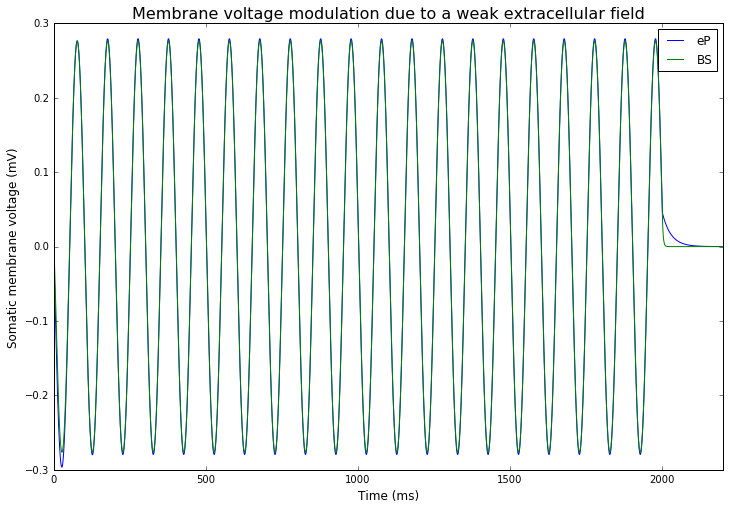

In [21]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
plt.legend()
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([0,2200])
plt.title('Membrane voltage modulation due to a weak extracellular field', fontsize=16)
# Note that the membrane voltages here (and below) denote the differencec to the membrane voltages at rest

## BS and eP model neurons in response to somatic input

In [22]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_dend_std=0, OUNoise_dend_mean=0 , E_amp=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _
else: 
    OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
    OUNoise_dend = 0.0*t

In [23]:
# Compute the input currents for the eP model
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=0,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

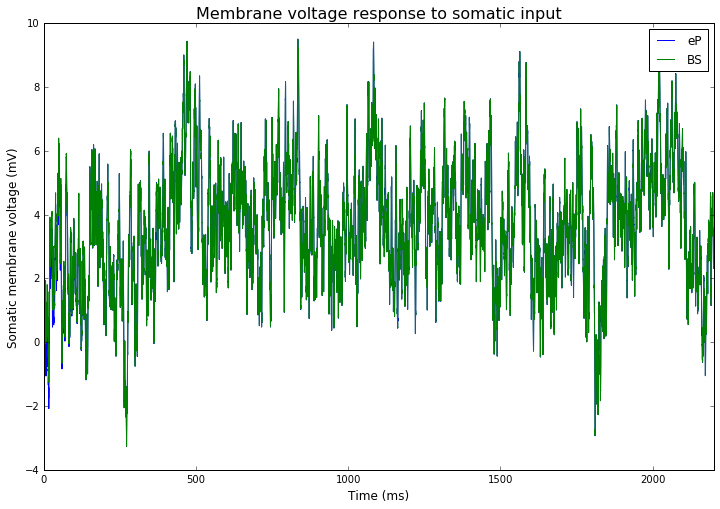

In [24]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
plt.legend()
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([0,2200])
plt.title('Membrane voltage response to somatic input', fontsize=16)

## BS and eP model neurons in response to input at the distal dendrite

In [25]:
if isNEURONInstalled:
    _ = runBSModel(OUNoise_soma_std=0, OUNoise_soma_mean= 0, E_amp=0)
    t, V_BS, OUNoise_soma, OUNoise_dend = _
else:
    OUNoise_soma = 0.0*t
    OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean

In [26]:
# Compute the input currents for the eP model
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=0,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

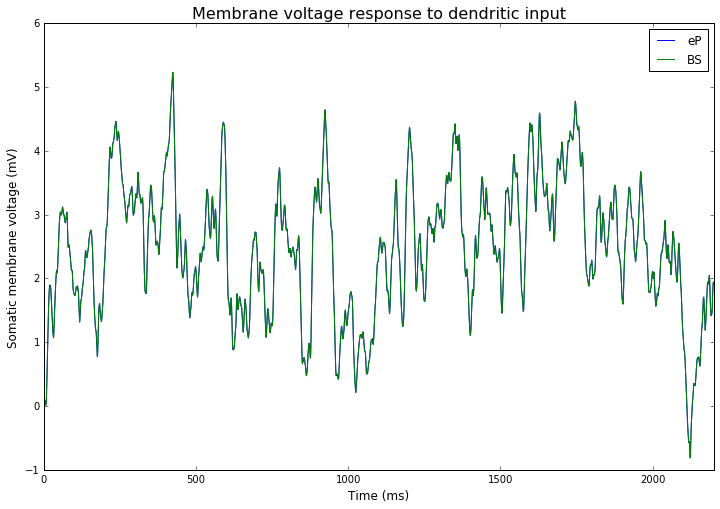

In [27]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
plt.legend()
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([0,2200])
plt.title('Membrane voltage response to dendritic input', fontsize=16)

## BS and eP model neurons in response to input at soma and dendrite + sinusoidal field

In [28]:
if isNEURONInstalled:
    _ = runBSModel()
    t, V_BS, OUNoise_soma, OUNoise_dend = _
else:
    OUNoise_soma = generateOUNoise(t*1e-3,0.5e-3,OUNoise_soma_std) + OUNoise_soma_mean
    OUNoise_dend = generateOUNoise(t*1e-3,0.5e-3,OUNoise_dend_std) + OUNoise_dend_mean

In [29]:
# Compute the input currents for the eP model
I_soma_eP = eP.computeEquivalentInputCurrentFromBSInput(t*1e-3,OUNoise_soma*1e-9,0)
I_dend_eP = eP.computeEquivalentInputCurrentFromBSInput_dend(t*1e-3,OUNoise_dend*1e-9,0)
I_ext_eP = I_soma_eP + I_dend_eP

# Run the eP model
t_eP, V_eP, E_eP = eP.runSim(dt=t[1]*1e-3,duration=duration*1e-3,E_onset=E_onset,E_amp=E_amp,E_freq=E_freq,
                             E_n=E_n,V0=0,I_ext=I_ext_eP)

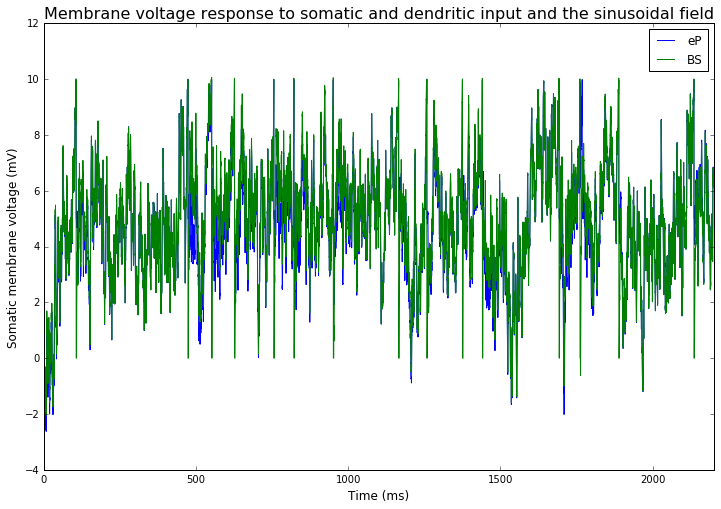

In [30]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
plt.legend()
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([0,2200])
plt.title('Membrane voltage response to somatic and dendritic input and the sinusoidal field', fontsize=16)

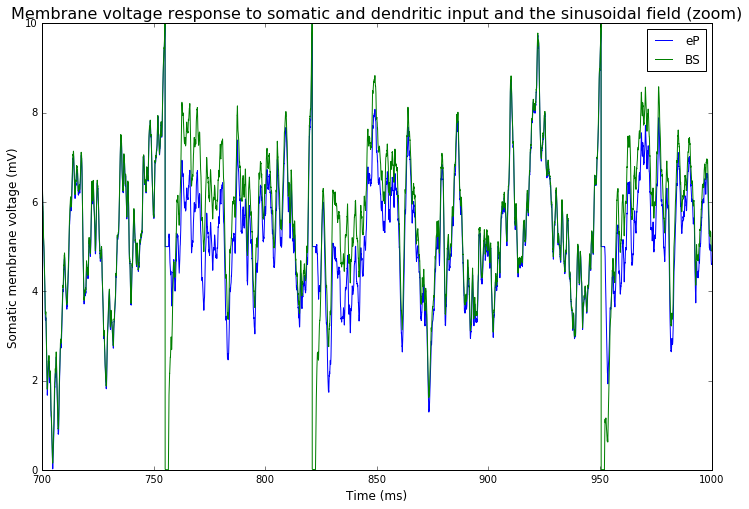

In [31]:
plt.figure(figsize=(12.,8.))
plt.plot(t_eP*1e3,V_eP*1e3,label='eP')
if isNEURONInstalled:
    plt.plot(t,V_BS,label='BS')
plt.legend()
plt.ylabel('Somatic membrane voltage (mV)', fontsize=12)
plt.xlabel('Time (ms)', fontsize=12)
plt.xlim([700,1000])
plt.ylim([0,10])
plt.title('Membrane voltage response to somatic and dendritic input and the sinusoidal field (zoom)', fontsize=16)